Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train")
data_dir_test = pathlib.Path("gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Test")

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='training',
            )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =tf.keras.utils.image_dataset_from_directory(
            data_dir_train,
            batch_size=batch_size,
            image_size=(img_height, img_width),
            seed=123,
            validation_split=0.2,
            subset='validation',
            )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

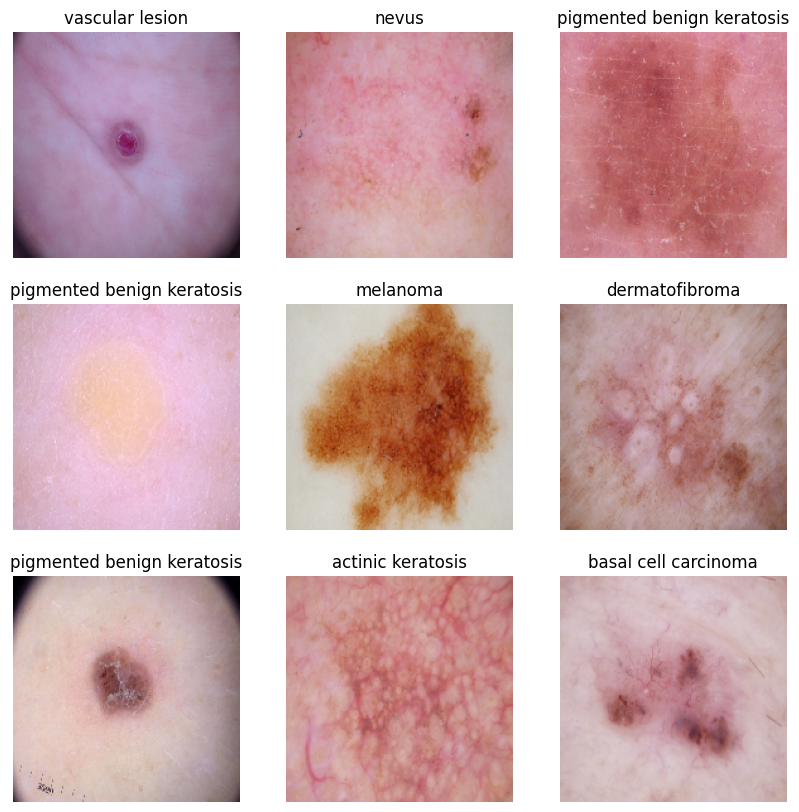

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from tensorflow.keras import layers, models
# Rescale layer
rescale = layers.Rescaling(1./255)

# Create the CNN model
model = models.Sequential([
    rescale,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 123s 446ms/step - accuracy: 0.1995 - loss: 2.1644 - val_accuracy: 0.3647 - val_loss: 1.8071
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3476 - loss: 1.8022 - val_accuracy: 0.3356 - val_loss: 1.8572
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3745 - loss: 1.6950 - val_accuracy: 0.4474 - val_loss: 1.5365
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4646 - loss: 1.5431 - val_accuracy: 0.4966 - val_loss: 1.4779
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4828 - loss: 1.4154 - val_accuracy: 0.4318 - val_loss: 1.5657
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5042 - loss: 1.4074 - val_accuracy: 0.5101 - val_loss: 1.5011
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5501 - loss: 1.2909 - val_accuracy: 0.5034 - val_loss: 1.5599
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5694 - loss: 1.2046 - val_accuracy: 0.5034 - val_l

### Visualizing training results

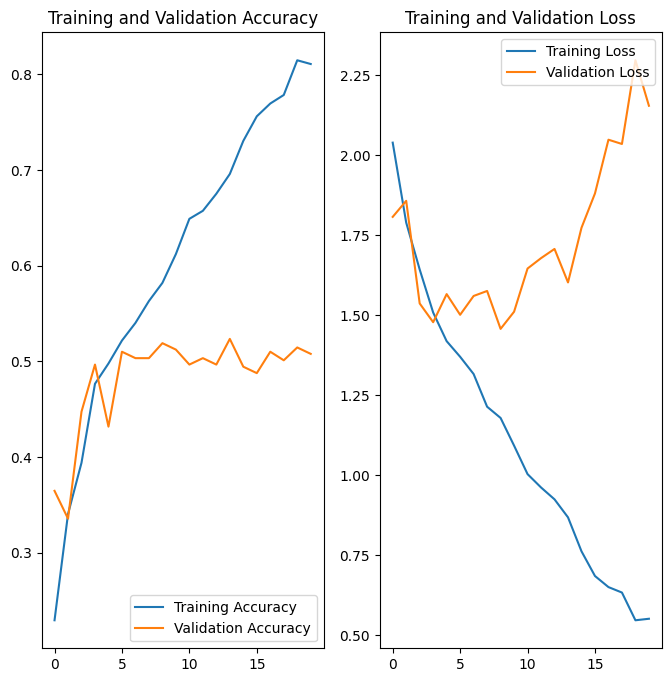

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here



1.  Training Accuracy and Loss:
The training accuracy shows a steady increase, reaching close to 90% by the end

  *   The training accuracy shows a steady increase, reaching close to 90% by the end of the training.
  *   The training loss decreases significantly, indicating that the model is learning from the training data.


2.  Validation Accuracy and Loss:

  *  The validation accuracy fluctuates and does not show a significant improvement over epochs. It peaks around 60%.
  *  The validation loss also fluctuates and does not show a consistent decreasing trend. It even increases in certain epochs.

* Overfitting:
  * The gap between training accuracy and validation accuracy indicates that the model is overfitting. The model performs well on the training data but does not generalize well to the validation data.
  * The decreasing training loss and the fluctuating validation loss further suggest overfitting.









In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
])



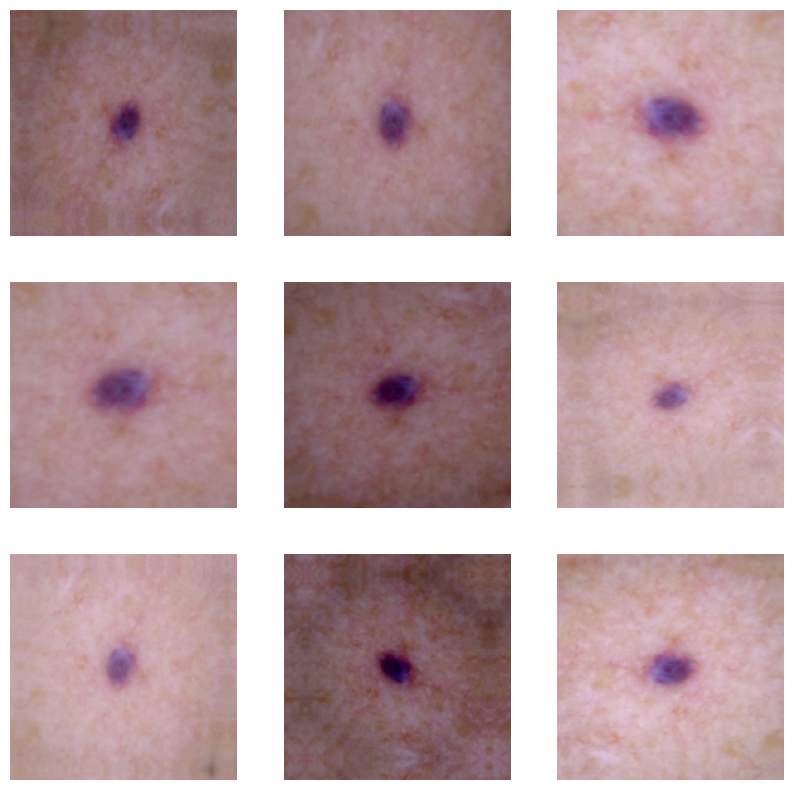

In [18]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [19]:
# Apply data augmentation to the train dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)


In [20]:
# Create the CNN model
model = models.Sequential([
    rescale,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

In [21]:
# compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 180, 180, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Train the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 269ms/step - accuracy: 0.1703 - loss: 14.3005 - val_accuracy: 0.2058 - val_loss: 2.1588
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 257ms/step - accuracy: 0.1873 - loss: 2.0531 - val_accuracy: 0.2058 - val_loss: 2.1401
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.1974 - loss: 2.0942 - val_accuracy: 0.2081 - val_loss: 2.0882
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.2025 - loss: 2.0407 - val_accuracy: 0.2058 - val_loss: 2.0507
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.2133 - loss: 2.0321 - val_accuracy: 0.2058 - val_loss: 2.0317
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - accuracy: 0.1874 - loss: 2.0257 - val_accuracy: 0.2058 - val_loss: 2.0245
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - accuracy: 0.2031 - loss: 2.0012 - val_accuracy: 0.2058 - val_loss: 2.0234
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - accuracy: 0.1985 - loss: 2.0054 - val_acc

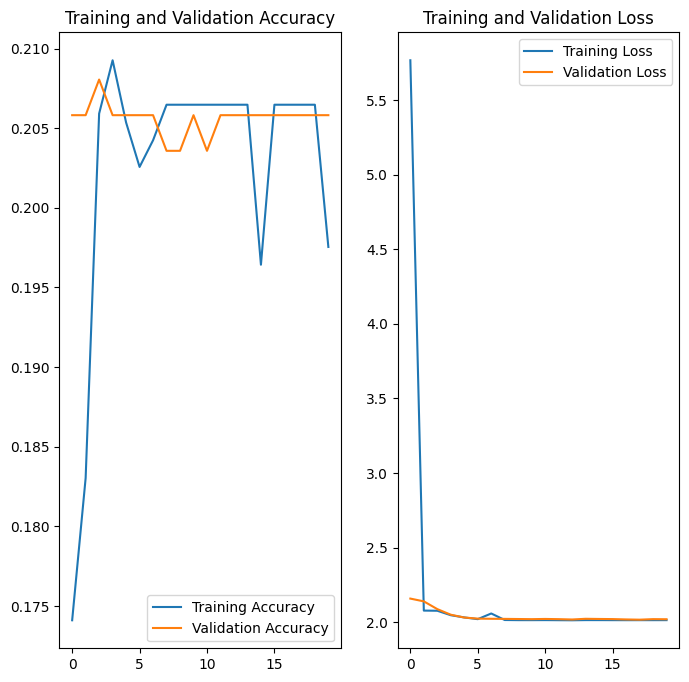

In [24]:
# Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Adding Dropout and Regularization


### Create the model, compile and train the model


In [25]:

#Adding Dropout and Regularization
from tensorflow.keras import regularizers
model = models.Sequential([
    rescale,
    data_augmentation,
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(512, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])



### Compiling the model

In [26]:
## Your code goes here
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs
## Training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 281ms/step - accuracy: 0.1815 - loss: 4.4200 - val_accuracy: 0.2058 - val_loss: 3.1650
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.1912 - loss: 3.0897 - val_accuracy: 0.2058 - val_loss: 3.0395
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.1915 - loss: 2.9319 - val_accuracy: 0.2215 - val_loss: 2.9216
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.1891 - loss: 2.8569 - val_accuracy: 0.2058 - val_loss: 2.8581
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.2153 - loss: 2.8018 - val_accuracy: 0.2394 - val_loss: 2.7919
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.1985 - loss: 2.7766 - val_accuracy: 0.2416 - val_loss: 2.7967
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 259ms/step - accuracy: 0.1946 - loss: 2.7387 - val_accuracy: 0.2058 - val_loss: 2.7364
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 258ms/step - accuracy: 0.1749 - loss: 2.7242 - val_accu

### Visualizing the results

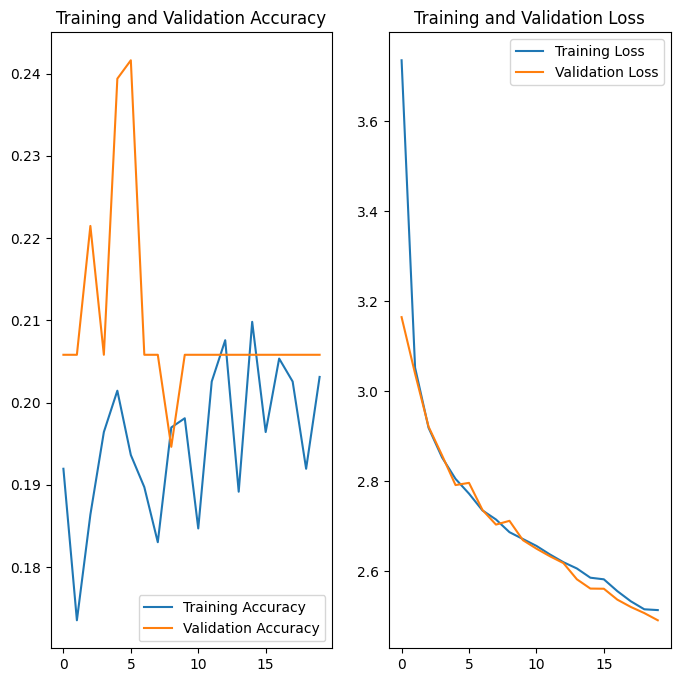

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [43]:
## original_df - > path_list, lesion_list
path_list=[]
lesion_list=[]

In [46]:
for i in class_names:
  for j in data_dir_train.glob(i+'/*.jpg'):
    path_list.append(str(j))
    lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns=['Path','Label'])
original_df

,Path,Label
0,gdrive/My Drive/upgrad/CNN_assignment/Skin_can...,actinic keratosis
1,gdrive/My Drive/upgrad/CNN_assignment/Skin_can...,actinic keratosis
2,gdrive/My Drive/upgrad/CNN_assignment/Skin_can...,actinic keratosis
3,gdrive/My Drive/upgrad/CNN_assignment/Skin_can...,actinic keratosis
4,gdrive/My Drive/upgrad/CNN_assignment/Skin_can...,actinic keratosis
...,...,...
2234,gdrive/My Drive/upgrad/CNN_assignment/Skin_can...,vascular lesion
2235,gdrive/My Drive/upgrad/CNN_assignment/Skin_can...,vascular lesion
2236,gdrive/My Drive/upgrad/CNN_assignment/Skin_can...,vascular lesion
2237,gdrive/My Drive/upgrad/CNN_assignment/Skin_can...,vascular lesion


## Class Distribution

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [29]:
import collections
import numpy as np

# Get the distribution of classes
class_counts = collections.Counter()
for x, y in train_ds:
    class_counts.update(y.numpy().tolist())




In [30]:
print(class_counts)

Counter({5: 370, 3: 352, 1: 309, 4: 277, 7: 142, 8: 115, 0: 92, 2: 77, 6: 58})


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
import Augmentor
import os

# Define a pipeline for each class with imbalance
pipelines = {}
for class_name in class_names:
    class_path = os.path.join(data_dir_train, class_name)
    # Print the path to check if it's correct and contains images
    print(f"Checking directory: {class_path}")
    if os.path.exists(class_path) and os.listdir(class_path):  # Check if directory exists and is not empty
        p = Augmentor.Pipeline(class_path)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(500)
        pipelines[class_name] = p
    else:
        print(f"Warning: Directory {class_path} is empty or does not exist.")


Checking directory: gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E6C516A2F50>: 100%|██████████| 500/500 [00:04<00:00, 113.36 Samples/s]


Checking directory: gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6C51708460>: 100%|██████████| 500/500 [00:04<00:00, 109.60 Samples/s]


Checking directory: gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6C516FBD60>: 100%|██████████| 500/500 [00:04<00:00, 113.35 Samples/s]


Checking directory: gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E6C50541D20>: 100%|██████████| 500/500 [00:14<00:00, 35.04 Samples/s]


Checking directory: gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/nevus
Initialised with 357 image(s) found.
Output directory set to gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7E6C745932B0>: 100%|██████████| 500/500 [00:13<00:00, 35.99 Samples/s]


Checking directory: gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6C505CEB60>: 100%|██████████| 500/500 [00:04<00:00, 112.56 Samples/s]


Checking directory: gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E6C5040A9B0>: 100%|██████████| 500/500 [00:07<00:00, 70.07 Samples/s]


Checking directory: gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6C50402440>: 100%|██████████| 500/500 [00:04<00:00, 102.32 Samples/s]


Checking directory: gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E6C50453DF0>: 100%|██████████| 500/500 [00:04<00:00, 106.26 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
import glob
import os
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029900.jpg_c08c0a2c-ebf2-48f6-b72a-98ecfc798649.jpg',
 'gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027802.jpg_034f5efb-3eb1-4e18-93e1-6396caa7fe08.jpg',
 'gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029133.jpg_9c73e3d9-bb5c-40aa-b7b0-a7d6295c0c48.jpg',
 'gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028854.jpg_5e77c01b-bf4a-4ba3-b9b4-fca21b5e1ee3.jpg',
 'gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026525.jpg_2ca5e5e2-03eb-4e36-a5b3-78e804bab1c2.jpg',
 'gdrive/My Drive/upgrad/CNN_assignment/Skin_cancer_ISIC/Train/actinic keratosis/output/actinic keratosis_original_ISIC_00290

In [36]:
import glob
import os

# Use glob.glob() to get the list of files
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(file_path)))
                   for file_path in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [38]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [47]:

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)


In [48]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [42]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [51]:
# Load the augmented dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory

augmented_train_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [52]:
augmented_val_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [53]:
## your code goes here
# Rebuild the model
model_balanced = models.Sequential([
    rescale,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [54]:
## your code goes here
model_balanced.compile(optimizer='adam',
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

#### **Todo:**  Train your model

In [55]:
# Train the model
history_balanced = model_balanced.fit(
    augmented_train_ds,
    validation_data=augmented_val_ds,
    epochs=30
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.2434 - loss: 2.0300 - val_accuracy: 0.4729 - val_loss: 1.3776
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.4560 - loss: 1.4376 - val_accuracy: 0.5212 - val_loss: 1.2582
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.5559 - loss: 1.1967 - val_accuracy: 0.5598 - val_loss: 1.1650
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.6167 - loss: 1.0363 - val_accuracy: 0.6206 - val_loss: 1.0823
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 64ms/step - accuracy: 0.6918 - loss: 0.8557 - val_accuracy: 0.6132 - val_loss: 1.1054
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.7360 - loss: 0.7263 - val_accuracy: 0.7060 - val_loss: 0.8435
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.7820 - loss: 0.5751 - val_accuracy: 0.7082 - val_loss: 0.8478
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.8302 - loss: 0.4741 - 

#### **Todo:**  Visualize the model results

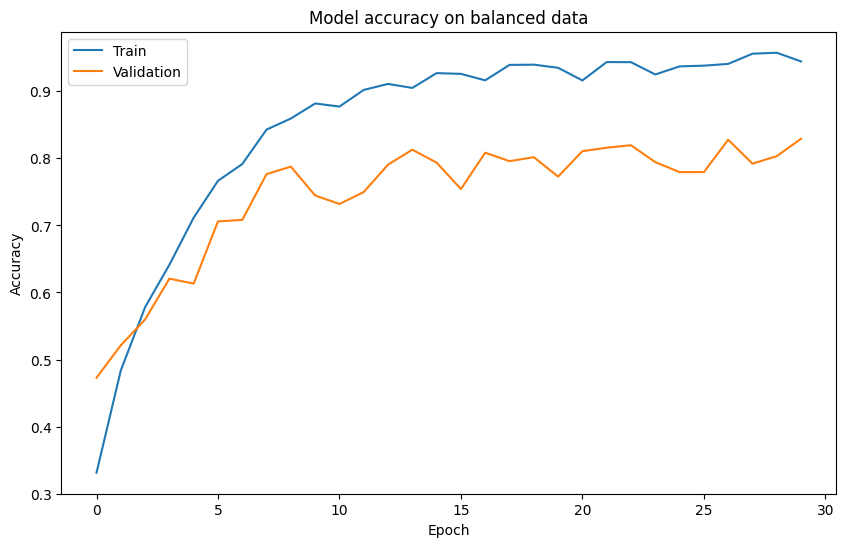

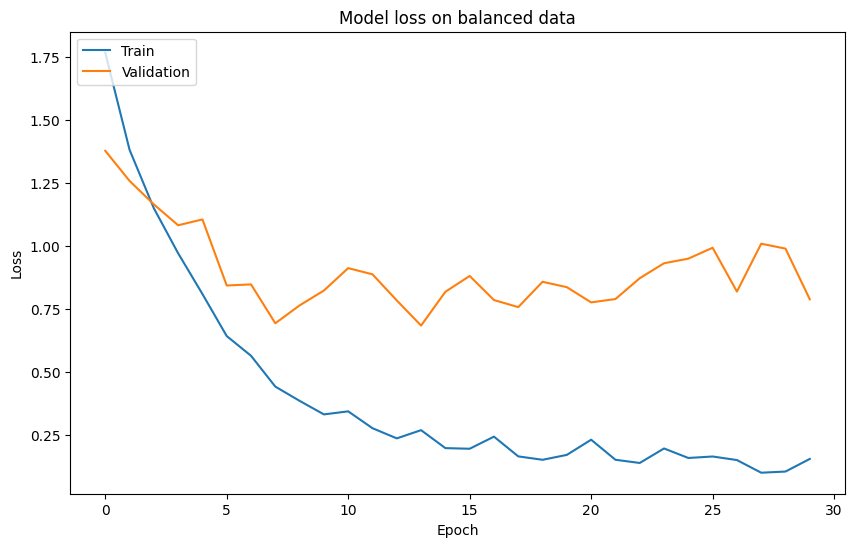

In [56]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 6))
plt.plot(history_balanced.history['accuracy'])
plt.plot(history_balanced.history['val_accuracy'])
plt.title('Model accuracy on balanced data')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history_balanced.history['loss'])
plt.plot(history_balanced.history['val_loss'])
plt.title('Model loss on balanced data')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
